In [43]:
from IPython.core.display import display
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# terminal colors
WHITE = '\033[39m'
CYAN = '\033[36m'
GREEN = '\033[32m'
RED = '\033[31m'

# color pallete
colors = {
    'cyan': '#1696d2',
    'gray': '#5c5859',
    'black': '#000000',
    'yellow': '#fdbf11',
    'orange': '#ca5800',
    'magenta': '#af1f6b',
    'green': '#408941',
    'red': '#a4201d'
}

# disable warnings
import warnings
warnings.filterwarnings('ignore')

# libraries version
print(f'Numpy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')
print(f'Seaborn: {sns.__version__}')

Numpy: 1.20.3
Pandas: 1.3.4
Matplotlib: 3.4.3
Seaborn: 0.11.2


# Diamonds Dataset Analysis

Dataset source: [-](#)

In [2]:
df = pd.read_csv('datasets/diamonds.csv')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


- **carat**: weight of the diamond  

- **cut**: quality of the cut `(Fair, Good, Very Good, Premium, Ideal)`

- **color**: diamond colour, `from J (worst) to D (best)*`

- **clarity**: a measurement of how clear the diamond is `*(I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))*`

- **depth**: total depth percentage = z / mean(x, y) = 2 * z / (x + y)

- **table**: width of top of diamond relative to widest point

- **price**: price in US dollars

- **x**: length in mm

- **y**: width in mm

- **z**: depth in mm

## EDA - Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [4]:
df.describe(include=np.number)

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [5]:
df.describe(include='object')

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


### Target Variable - price

#### Target Distribuition

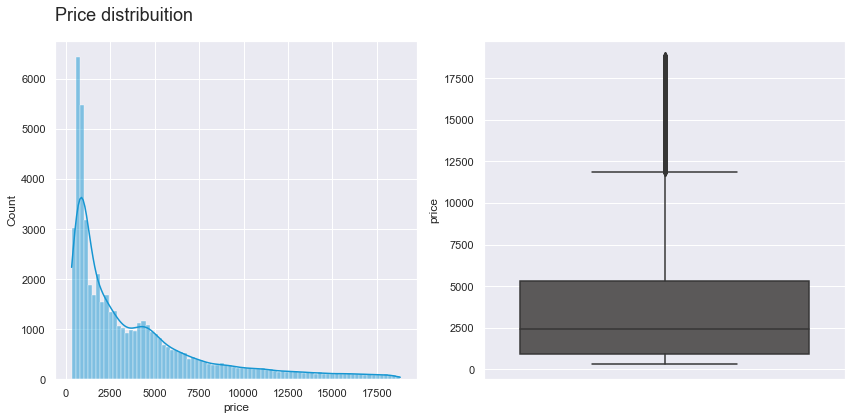

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.histplot(data=df, x='price', kde=True, ax=ax[0], color=colors['cyan'])
ax[0].set_title('Price distribuition', size=18, pad=20, loc='left')
sns.boxplot(data=df, y='price', ax=ax[1], color=colors['gray'])
fig.tight_layout()

#### Correlation Heatmap

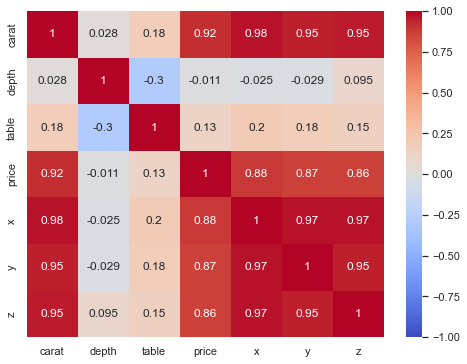

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1);

#### Relational plot with highest correlated feature

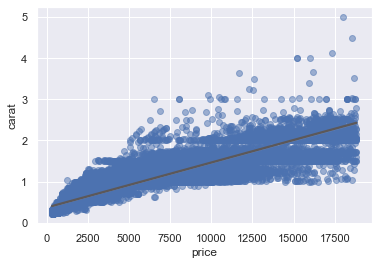

In [ ]:
sns.regplot(data=df, x='price', y='carat',
           scatter_kws={'alpha':0.5}, line_kws={'color':colors['gray']});

#### Category correlation

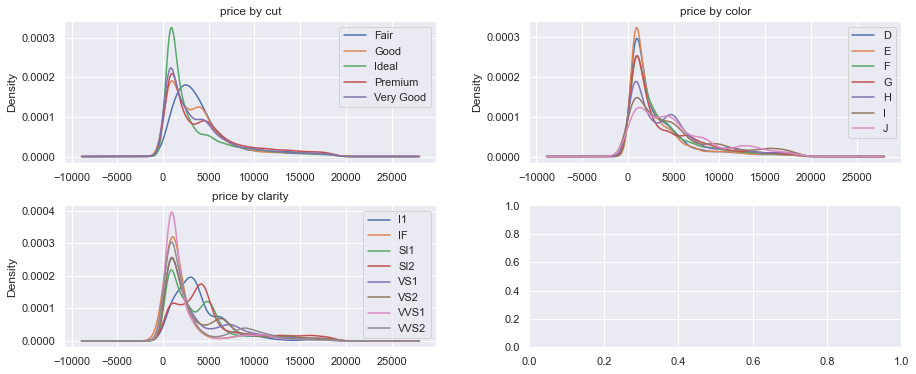

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
fig.subplots_adjust(hspace=.3, wspace=.25)
df.groupby('cut').price.plot(kind='kde', ax=axes[0][0], legend=True, title='price by cut')
df.groupby('color').price.plot(kind='kde', ax=axes[0][1], legend=True, title='price by color')
df.groupby('clarity').price.plot(kind='kde', ax=axes[1][0], legend=True, title='price by clarity');
#fig.tight_layout();

## Modeling - First Cicle with ElasticNet

### Split data into train/test

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Pre-processing

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

In [20]:
# numerical features
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()

numeric_features_pipeline = Pipeline([
        ('num_impute', SimpleImputer(strategy='mean')),
        ('std', StandardScaler())
])

# categorical features
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

categorical_features_pipeline = Pipeline([
        ('cat_impute', SimpleImputer(strategy='constant', fill_value='unknow')),
        ('ordinal_enc', OrdinalEncoder())
])

# pre-processing pipeline
pre_processing = ColumnTransformer([
    ('numeric_transformer', numeric_features_pipeline, numeric_features),
    ('categorical_transformer', categorical_features_pipeline ,categorical_features)
])

### Pipeline and GridSearch

In [44]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import ElasticNet

regr_pipeline = Pipeline([
    ('pp', pre_processing),
    ('regr', ElasticNet(random_state=42))
])

regr_params_grid = {
    'regr__alpha': range(1,10),
    'regr__l1_ratio': np.linspace(0,1,11),
    'regr__max_iter': [2000, 3000],
}

splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

metrics = 'neg_mean_absolute_error'

regr_grid = GridSearchCV(
                        estimator = regr_pipeline,
                        param_grid = regr_params_grid,
                        scoring = metrics,
                        cv = splitter,
                        verbose = 10
            )

regr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 198 candidates, totalling 990 fits
[CV 1/5; 1/198] START regr__alpha=1, regr__l1_ratio=0.0, regr__max_iter=2000....
[CV 1/5; 1/198] END regr__alpha=1, regr__l1_ratio=0.0, regr__max_iter=2000;, score=-1175.752 total time=   1.3s
[CV 2/5; 1/198] START regr__alpha=1, regr__l1_ratio=0.0, regr__max_iter=2000....
[CV 2/5; 1/198] END regr__alpha=1, regr__l1_ratio=0.0, regr__max_iter=2000;, score=-1178.246 total time=   1.9s
[CV 3/5; 1/198] START regr__alpha=1, regr__l1_ratio=0.0, regr__max_iter=2000....
[CV 3/5; 1/198] END regr__alpha=1, regr__l1_ratio=0.0, regr__max_iter=2000;, score=-1179.606 total time=   1.0s
[CV 4/5; 1/198] START regr__alpha=1, regr__l1_ratio=0.0, regr__max_iter=2000....
[CV 4/5; 1/198] END regr__alpha=1, regr__l1_ratio=0.0, regr__max_iter=2000;, score=-1183.188 total time=   1.4s
[CV 5/5; 1/198] START regr__alpha=1, regr__l1_ratio=0.0, regr__max_iter=2000....
[CV 5/5; 1/198] END regr__alpha=1, regr__l1_ratio=0.0, regr__max_iter=2000;, score=-

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('numeric_transformer',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['carat',
                                                                          'depth',
                                                                          'table',
                                                                          'x',
                                  

### Metrics

In [46]:
regr_grid.best_params_

{'regr__alpha': 1, 'regr__l1_ratio': 1.0, 'regr__max_iter': 2000}

In [50]:
pd.DataFrame(regr_grid.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__alpha,param_regr__l1_ratio,param_regr__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,0.197257,0.122314,0.023686,0.018632,1,1.0,2000,"{'regr__alpha': 1, 'regr__l1_ratio': 1.0, 'reg...",-862.212129,-864.960009,-863.622345,-866.618834,-865.121900,-864.507043,1.489444,1
21,0.121354,0.019218,0.020180,0.013686,1,1.0,3000,"{'regr__alpha': 1, 'regr__l1_ratio': 1.0, 'reg...",-862.212129,-864.960009,-863.622345,-866.618834,-865.121900,-864.507043,1.489444,1
42,0.092945,0.008148,0.012698,0.000651,2,1.0,2000,"{'regr__alpha': 2, 'regr__l1_ratio': 1.0, 'reg...",-863.306420,-865.952742,-864.743739,-867.346865,-866.490946,-865.568142,1.411267,3
43,0.088192,0.004366,0.013274,0.000997,2,1.0,3000,"{'regr__alpha': 2, 'regr__l1_ratio': 1.0, 'reg...",-863.306420,-865.952742,-864.743739,-867.346865,-866.490946,-865.568142,1.411267,3
65,0.101596,0.016115,0.020105,0.010338,3,1.0,3000,"{'regr__alpha': 3, 'regr__l1_ratio': 1.0, 'reg...",-864.473929,-867.056290,-865.929927,-868.759890,-867.917787,-866.827565,1.504668,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,1.434288,0.162288,0.017254,0.001426,8,0.0,2000,"{'regr__alpha': 8, 'regr__l1_ratio': 0.0, 'reg...",-2154.526009,-2158.982854,-2158.629447,-2167.275004,-2157.543163,-2159.391295,4.242327,193
178,0.074251,0.026526,0.052566,0.071326,9,0.1,2000,"{'regr__alpha': 9, 'regr__l1_ratio': 0.1, 'reg...",-2161.473380,-2165.817482,-2165.499819,-2174.257242,-2164.483279,-2166.306240,4.261158,195
179,0.072257,0.019157,0.013711,0.001554,9,0.1,3000,"{'regr__alpha': 9, 'regr__l1_ratio': 0.1, 'reg...",-2161.473380,-2165.817482,-2165.499819,-2174.257242,-2164.483279,-2166.306240,4.261158,195
176,0.837216,0.032798,0.013295,0.000266,9,0.0,2000,"{'regr__alpha': 9, 'regr__l1_ratio': 0.0, 'reg...",-2217.525041,-2220.870003,-2220.988682,-2230.566850,-2220.458482,-2222.081812,4.428513,197


In [57]:
y_pred_train = regr_grid.predict(X_train)
y_pred_test = regr_grid.predict(X_test)

In [59]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

display_metrics = lambda metric, y, y_pred: print(f'{CYAN}{metric.__name__}{WHITE}: {metric(y, y_pred):.2f}')

print('Train metrics:')
for metric in [r2_score, mean_absolute_error, mean_squared_error]:
    display_metrics(metric, y_train, y_pred_train)

print('Test metrics:')
for metric in [r2_score, mean_absolute_error, mean_squared_error]:
    display_metrics(metric, y_test, y_pred_test)


Train metrics:
r2_score: 0.89
mean_absolute_error: 864.13
mean_squared_error: 1830219.91
Test metrics:
r2_score: 0.89
mean_absolute_error: 859.82
mean_squared_error: 1826232.12


In [82]:
y_pred_test.max(), y.max()

(32202.894933036325, 18823)

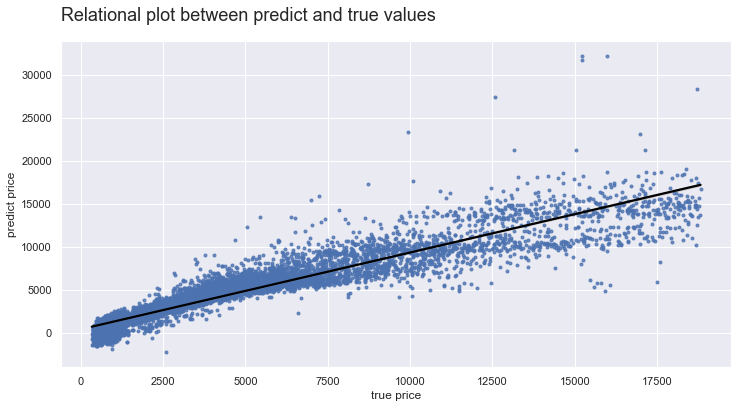

In [98]:
plt.figure(figsize=(12,6))
sns.regplot(x=y_test, y=y_pred_test, marker='.', line_kws={"color": "black"})
plt.xlabel('true price')
plt.ylabel('predict price')
plt.title('Relational plot between predict and true values', size=18, pad=20, loc='left');